#Stock Prediction with LSTM and Technical indicators


In [88]:
!pip install yfinance
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py39hd257fcd_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.9/dist-packages/ lib/python3.9/site-packages/talib --strip-components=3
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime 
from datetime import date
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4335    0  4335    0     0  25057      0 --:--:-- --:--:-- --:--:-- 25057
100  517k  100  517k    0     0  1107k      0 --:--:-- --:--:-- --:--:-- 1107k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4343    0  4343    0     0  27314      0 --:--:-- --:--:-- --:--:-- 27143
100  389k  100  389k    0     0   897k      0 --:--:-- --:--:-- --:--:--  897k


In [89]:

# Define the start and end dates for the data
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime.today()

# Use the ticker symbol "TSLA" for Tesla stock
ticker = yf.Ticker('TSLA')

# Get the historical market data for the desired date range
data = ticker.history(start=start_date, end=end_date)

# Select only the "Close" column
data = data[['Close']]

# Rename the "Close" column to "Price"
data = data.rename(columns={'Close': 'Price'})
data.index = data.index.strftime('%Y-%m-%d')
data.index = pd.to_datetime(data.index)
# Print the first few rows of the data
print(data.head())
print(f'There are {data.shape[0]} days in the dataset')
data.tail(20)

               Price
Date                
2010-06-29  1.592667
2010-06-30  1.588667
2010-07-01  1.464000
2010-07-02  1.280000
2010-07-06  1.074000
There are 3212 days in the dataset


,Price
Date,
2023-03-06,193.809998
2023-03-07,187.710007
2023-03-08,182.000000
2023-03-09,172.919998
2023-03-10,173.440002
2023-03-13,174.479996
2023-03-14,183.259995
2023-03-15,180.449997
2023-03-16,184.130005


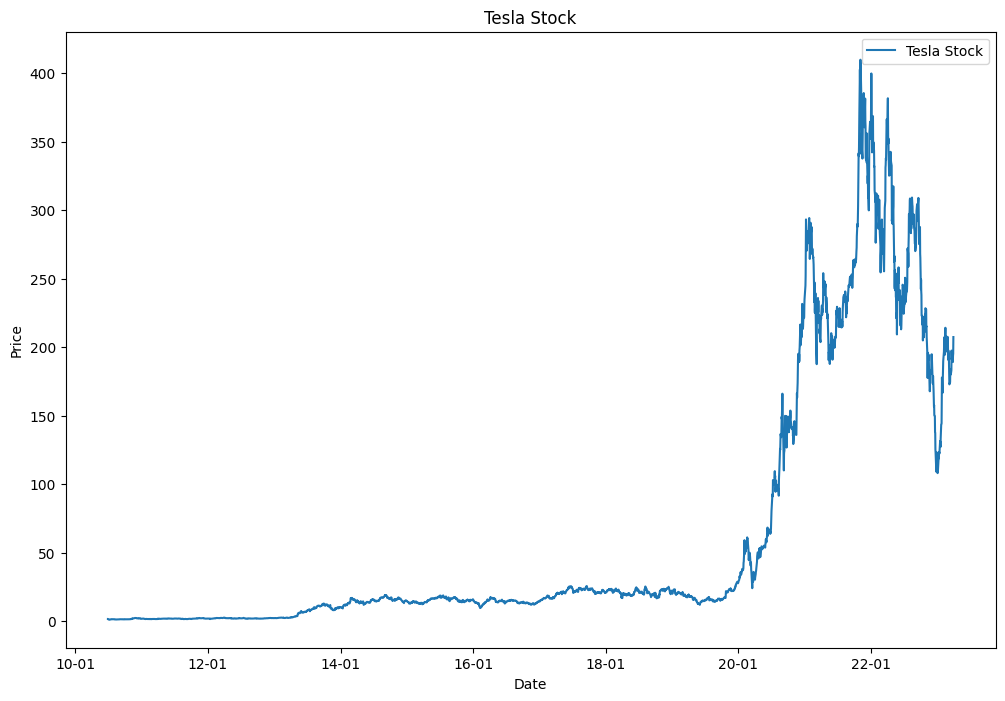

In [90]:
fig, ax= plt.subplots(figsize=(12,8))
plt.plot(data.index, data['Price'], label='Tesla Stock')
date_form = DateFormatter("%y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tesla Stock')
plt.legend()

plt.show()

In [91]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()
    
    # Set lookback period
    n = 10

    # Calculate momentum technical indicator
    dataset['momentum'] = dataset['Price'].diff(n)
    # Calculate RSI for last 7 days
    delta = dataset['Price'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=7).mean()
    avg_loss = loss.rolling(window=7).mean()
    rs = avg_gain / avg_loss
    dataset['RSI'] = 100 - (100 / (1 + rs))

    return dataset

In [92]:
df = get_technical_indicators(data)
df = df.dropna()
df.tail(20)

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
Date,,,,,,,,,,,,
2023-03-06,193.809998,199.355715,200.539047,190.440976,198.275196,7.834220,6.454916,213.448878,187.629216,194.842367,-14.500000,40.514460
2023-03-07,187.710007,198.045715,200.430953,190.238682,196.649782,6.411100,6.656441,213.743834,187.118071,190.087460,-9.659988,39.685041
2023-03-08,182.000000,194.384286,199.823334,189.628409,194.395970,4.767560,7.700491,215.224315,184.422353,184.695820,-18.860001,17.482869
2023-03-09,172.919998,189.699999,198.685715,188.390749,191.091974,2.701225,9.678540,218.042794,179.328635,176.845272,-29.150009,14.794929
2023-03-10,173.440002,185.509999,197.359525,187.283286,188.376286,1.093000,11.106557,219.572638,175.146412,174.575092,-23.440002,16.783697
2023-03-13,174.479996,183.164285,195.795715,186.334894,186.238395,-0.096499,11.916413,219.628541,171.962888,174.511695,-33.150009,25.360141
2023-03-14,183.259995,181.088571,195.146667,186.107124,185.780180,-0.326944,12.221126,219.588919,170.704415,180.343895,-22.450012,29.366654
2023-03-15,180.449997,179.179999,194.470952,185.688078,184.960152,-0.727926,12.635793,219.742539,169.199366,180.414629,-22.320007,30.376023
2023-03-16,184.130005,178.668570,193.274762,185.572665,184.832437,-0.740228,12.352595,217.979952,168.569572,182.891546,-6.769989,44.339025


In [93]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.axhline(y=70, color='black', linestyle='-')
    plt.axhline(y=30, color='black', linestyle='-')
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.plot(dataset['RSI'],label='Relative Strength Index', color='y')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title(f'Technical indicators for Tesla for the {last_days} days')
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.title('MACD')
    plt.legend()
    plt.show()


<Figure size 1600x1000 with 0 Axes>

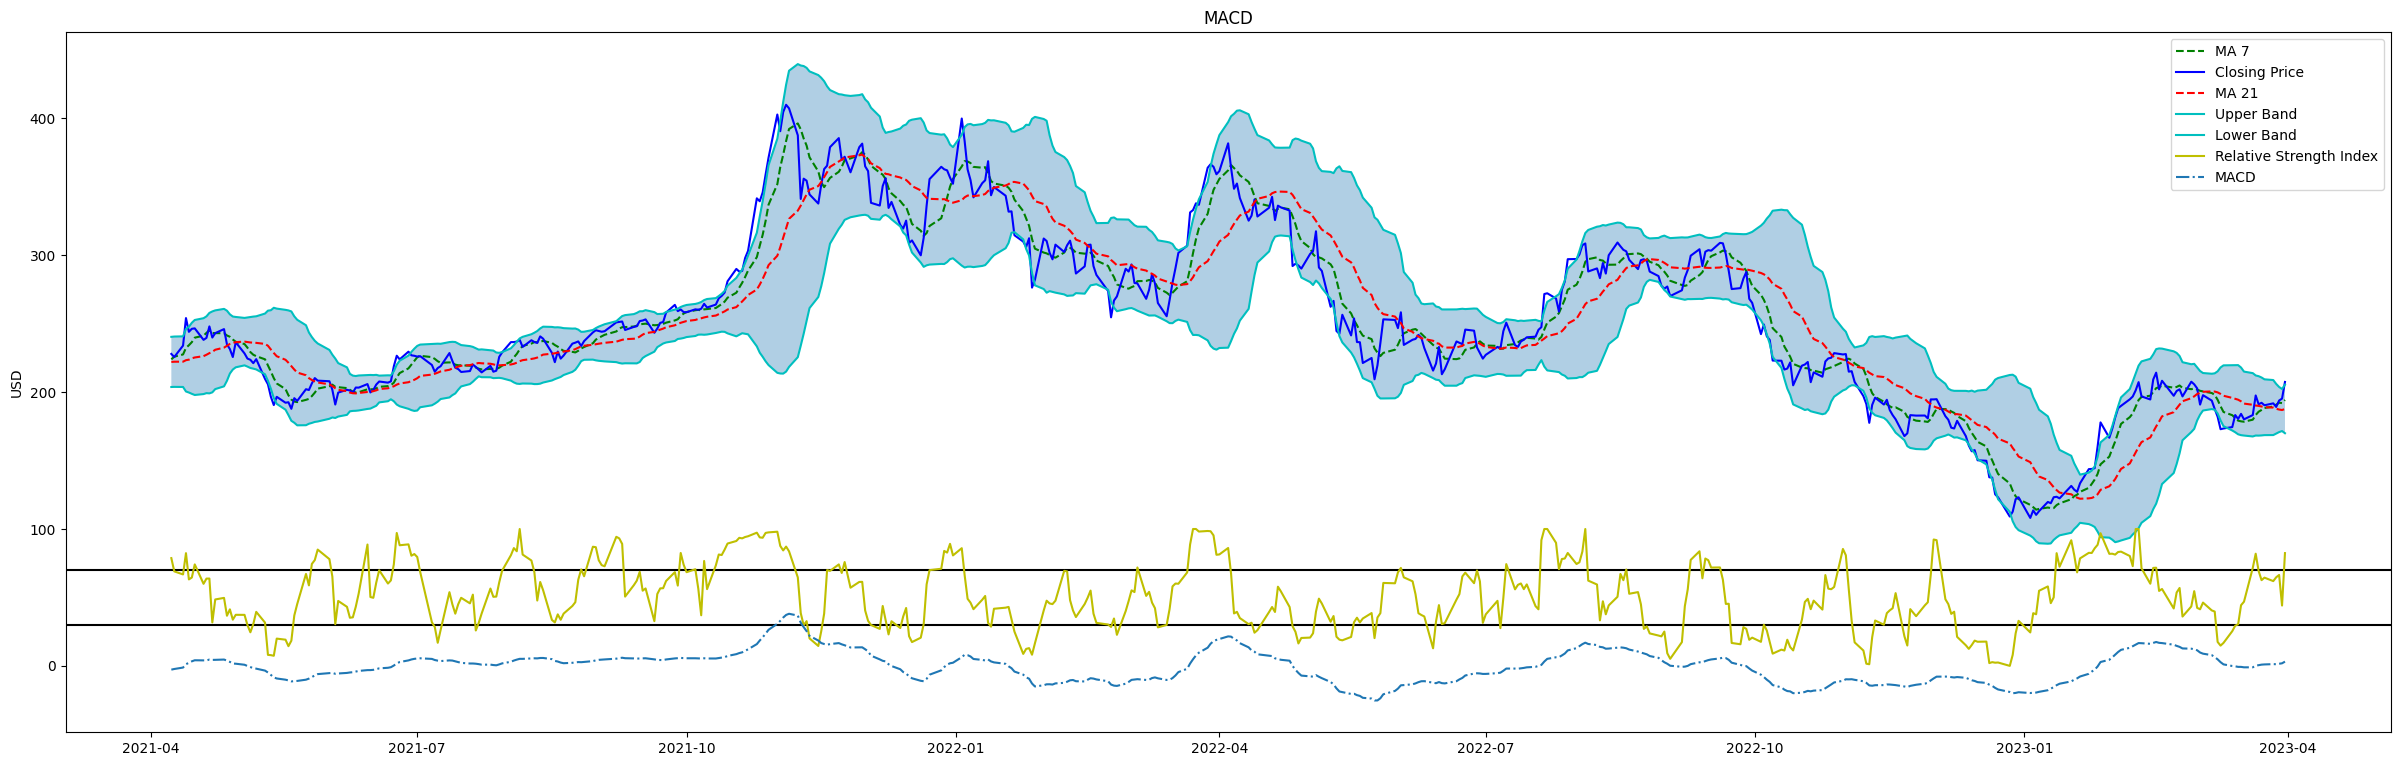

In [94]:
plot_technical_indicators(df, 500)

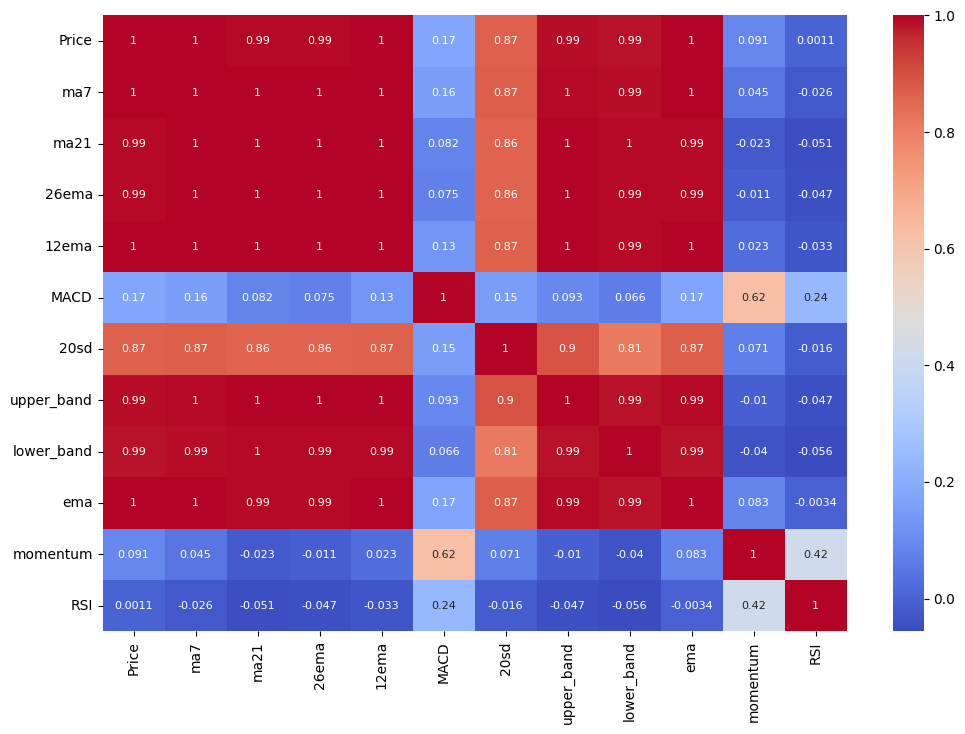

In [95]:

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm',annot_kws={"fontsize":8})
plt.show()

In [96]:
data_training = df[df.index < '2021-01-31'].copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
Date,,,,,,,,,,,,
2010-07-28,1.381333,1.381238,1.327460,1.340849,1.360547,0.019699,0.149731,1.626922,1.027999,1.380945,0.058666,33.787272
2010-07-29,1.356667,1.381714,1.316222,1.342285,1.359935,0.017650,0.137159,1.590540,1.041904,1.364760,0.030667,51.029040
2010-07-30,1.329333,1.379048,1.303873,1.341128,1.355124,0.013995,0.122269,1.548411,1.059335,1.341142,-0.046667,44.927389
2010-08-02,1.394667,1.378286,1.300571,1.345837,1.361320,0.015483,0.118611,1.537793,1.063350,1.376825,-0.066000,48.648745
2010-08-03,1.463333,1.384571,1.309302,1.356028,1.377259,0.021231,0.123660,1.556622,1.061981,1.434497,0.110000,58.918946
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-25,293.600006,282.789995,260.451269,255.766085,276.418997,20.652912,27.210636,314.872540,206.029997,289.770609,0.260010,64.065634
2021-01-26,294.363342,284.603808,264.214920,258.625141,279.179665,20.554524,26.100484,316.415889,212.013951,292.832431,23.966675,71.969095
2021-01-27,288.053345,286.413334,267.427460,260.805008,280.544847,19.739839,24.569405,316.566271,218.288650,289.646373,4.906677,71.894458


In [97]:
data_testing = df[df.index >= '2021-01-31'].copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
Date,,,,,,,,,,,,
2021-02-01,279.936676,283.021907,274.480000,263.598550,278.136095,14.537545,17.078406,308.636812,240.323188,276.759997,4.550018,48.510992
2021-02-02,290.929993,284.267147,277.132698,265.623101,280.104387,14.481286,14.857964,306.848627,247.416770,286.206661,9.413330,56.369665
2021-02-03,284.896667,283.023812,279.115556,267.050773,280.841661,13.790888,12.738347,304.592249,253.638862,285.333332,1.413330,43.100252
2021-02-04,283.329987,281.447619,280.939047,268.256640,281.224480,12.967840,10.079367,301.097781,260.780313,283.997768,1.666656,41.363095
2021-02-05,284.076660,280.879521,282.466824,269.428494,281.663277,12.234783,7.598838,297.664501,267.269148,284.050363,1.863342,46.590049
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,191.809998,189.507143,188.740476,187.399185,188.668757,1.269572,10.051573,208.843623,168.637330,191.522208,17.330002,61.940286
2023-03-28,189.190002,190.801429,187.862381,187.531838,188.748949,1.217111,9.077109,206.016599,169.708163,189.967404,5.930008,64.717346
2023-03-29,193.880005,192.320001,187.299048,188.002073,189.538342,1.536269,8.242839,203.784727,170.813369,192.575805,13.430008,66.429680


In [98]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled


(2646, 12)


array([[7.09437355e-04, 5.24978372e-04, 1.35123466e-04, ...,
        6.54425152e-04, 2.49704832e-01, 3.37872721e-01],
       [6.25307777e-04, 5.26648507e-04, 9.36372034e-05, ...,
        5.98927438e-04, 2.49435349e-01, 5.10290404e-01],
       [5.32077813e-04, 5.17297529e-04, 4.80490480e-05, ...,
        5.17945060e-04, 2.48691026e-01, 4.49273888e-01],
       ...,
       [9.78478129e-01, 1.00000000e+00, 9.82463261e-01, ...,
        9.89075463e-01, 2.96365788e-01, 7.18944581e-01],
       [9.45814360e-01, 9.98477158e-01, 9.92526611e-01, ...,
        9.63542547e-01, 1.88247292e-01, 4.53047715e-01],
       [8.98177525e-01, 9.88972781e-01, 1.00000000e+00, ...,
        9.23105154e-01, 8.40115400e-02, 2.86208087e-01]])

In [99]:
X_train = []
y_train = []
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2586, 60, 12), (2586,))

In [100]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            12600     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_13 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_14 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_14 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_15 (LSTM)              (None, 120)              

In [101]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
41/41 [==============================] - 39s 687ms/step - loss: 0.0138
Epoch 2/50
41/41 [==============================] - 15s 351ms/step - loss: 0.0035
Epoch 3/50
41/41 [==============================] - 14s 331ms/step - loss: 0.0013
Epoch 4/50
41/41 [==============================] - 14s 336ms/step - loss: 0.0011
Epoch 5/50
41/41 [==============================] - 14s 338ms/step - loss: 0.0013
Epoch 6/50
41/41 [==============================] - 14s 336ms/step - loss: 0.0011
Epoch 7/50
41/41 [==============================] - 14s 343ms/step - loss: 0.0012
Epoch 8/50
41/41 [==============================] - 14s 346ms/step - loss: 0.0013
Epoch 9/50
41/41 [==============================] - 17s 402ms/step - loss: 0.0011
Epoch 10/50
41/41 [==============================] - 15s 359ms/step - loss: 0.0013
Epoch 11/50
41/41 [==============================] - 14s 339ms/step - loss: 0.0013
Epoch 12/50
41/41 [==============================] - 13s 330ms/step - loss: 8.0926e-04
Epoch 13/

In [102]:
past_60 = data_training.tail(60)

dt = past_60.append(data_testing, ignore_index = True)
dt

<ipython-input-102-5aa1e953533c>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dt = past_60.append(data_testing, ignore_index = True)


,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,RSI
0,141.300003,136.869522,141.810952,139.513331,138.628926,-0.884405,5.622215,153.055381,130.566522,138.524691,0.653336,51.882116
1,140.326660,136.902854,141.922062,139.573577,138.890115,-0.683462,5.565769,153.053600,130.790525,139.726004,-0.553345,50.391305
2,146.029999,137.541425,142.125078,140.051831,139.988559,-0.063272,5.637114,153.399307,130.850850,143.928667,4.100006,56.563875
3,143.316666,138.680950,142.189047,140.293671,140.500575,0.206905,5.642925,153.474897,130.903197,143.520666,3.106659,63.057948
4,140.419998,139.177617,141.986824,140.303028,140.488179,0.185151,5.625763,153.238350,130.735299,141.453554,0.326660,55.460162
...,...,...,...,...,...,...,...,...,...,...,...,...
601,191.809998,189.507143,188.740476,187.399185,188.668757,1.269572,10.051573,208.843623,168.637330,191.522208,17.330002,61.940286
602,189.190002,190.801429,187.862381,187.531838,188.748949,1.217111,9.077109,206.016599,169.708163,189.967404,5.930008,64.717346
603,193.880005,192.320001,187.299048,188.002073,189.538342,1.536269,8.242839,203.784727,170.813369,192.575805,13.430008,66.429680
604,195.279999,191.991429,186.942381,188.541178,190.421674,1.880496,7.682974,202.308328,171.576433,194.378601,11.149994,44.078261


In [103]:
inputs = scalar.transform(dt)
print(inputs.shape)
inputs

(606, 12)


array([[0.47793808, 0.47561939, 0.51874048, ..., 0.47090077, 0.25542839,
        0.51882116],
       [0.47461824, 0.47573627, 0.51915066, ..., 0.4750199 , 0.24381437,
        0.50391305],
       [0.49407095, 0.47797544, 0.51990011, ..., 0.48943023, 0.28860177,
        0.56563875],
       ...,
       [0.65727571, 0.67005843, 0.68666321, ..., 0.65623433, 0.37840082,
        0.6642968 ],
       [0.66205075, 0.66890628, 0.68534654, ..., 0.66241586, 0.35645623,
        0.44078261],
       [0.7035938 , 0.67707652, 0.68825762, ..., 0.69231871, 0.51218496,
        0.8239971 ]])

In [104]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((546, 60, 12), (546,))

In [105]:
y_pred = regressor.predict(X_test)

18/18 [==============================] - 3s 98ms/step


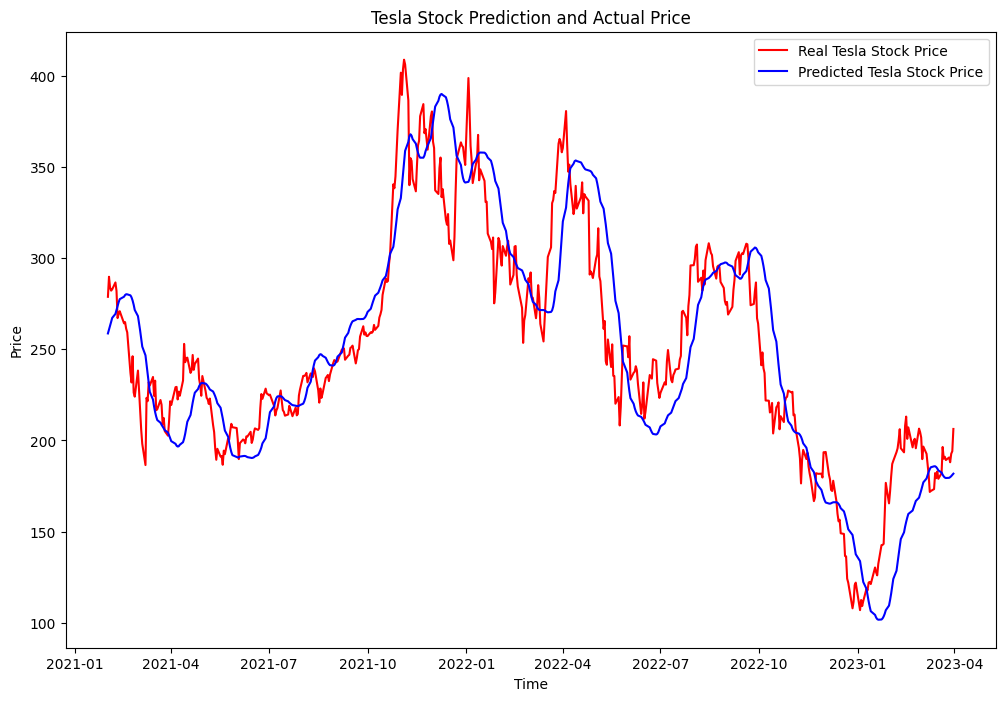

In [106]:
scale = 1/scalar.scale_[0]
y_pred = y_pred*scale
y_test = y_test*scale
# Visualising the results
plt.figure(figsize=(12,8))
plt.plot(data_testing.index,y_test, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(data_testing.index,y_pred, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Prediction and Actual Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()